# Kaggle Workshop

Kaggle 是一个机器学习爱好者交流平台，可以在上面参加比赛，进行中的比赛一般会有奖金，能把测试数据集结果刷到前几名的都有奖金。大家可以组队刷比赛分数，可以在论坛交流。上面有类似jupyter notebook的叫做kernel，可以跑自己的程序，代码可以分享给别人，有点类似github。Google也有类似产品colab，都可以使用GPU资源。

## 1. Kaggle house price predict
https://www.kaggle.com/c/house-prices-advanced-regression-techniques


![基本信息](house-prices-advanced-regression-techniques1.png)
有79个可解释的变量，位置、房间数、装修情况等等来预测房子价格，但这些都没有谈价来的影响力大。


![评分标准](house-prices-advanced-regression-techniques2.png)
Root Mean Square Error(对数均方根误差): 

给定预测值$\hat y_1, \ldots, \hat y_n$和对应的真实标签$y_1,\ldots,
y_n$，它的定义为

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log(y_i)-\log(\hat
y_i)\right)^2}$$


![数据](house-prices-advanced-regression-techniques3.png)
https://github.com/LaoLiulaoliu/MachineLearning/tree/master/kaggle/house_price



![规则](house-prices-advanced-regression-techniques4.png)
规则：
一人一个帐号，一天最多提交5次，可以组队，但请尊重比赛，不要手动标注结果。


![排行榜](house-prices-advanced-regression-techniques5.png)
排行榜

## 2. Data exploration

下面我们导入需要用到的python library，看一下数据的情况

In [1]:
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

import numpy as np
import pandas as pd
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import missingno
from IPython.display import display, HTML
display(HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
"""))

### 加载数据

看数据统计，有数值型数据，有分类型数据，还有NaN。有的变量的均值大小不一。

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### 理解数据

#### 查看SalePrice 的分布

Skewness: 1.882876
Kurtosis: 6.536282


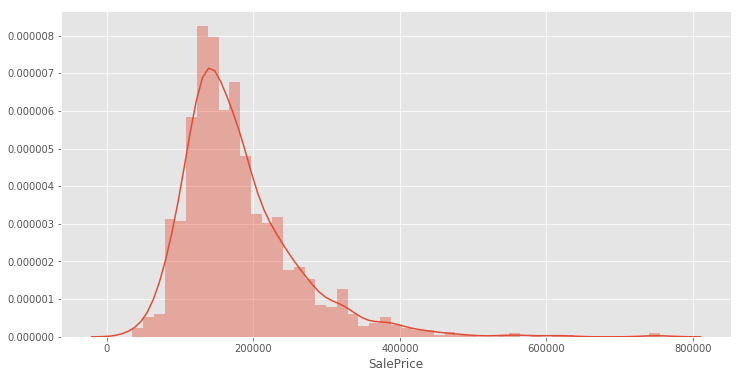

In [5]:
f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(train_data['SalePrice'])

print("Skewness: %f" % train_data['SalePrice'].skew())
print("Kurtosis: %f" % train_data['SalePrice'].kurt())

Skewness: 0.121335
Kurtosis: 0.809532


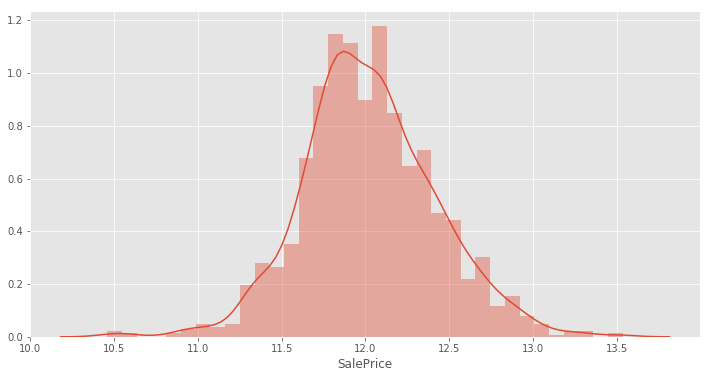

In [6]:
f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(np.log(train_data['SalePrice']))


print("Skewness: %f" % np.log(train_data['SalePrice']).skew()) # -> 0
print("Kurtosis: %f" % np.log(train_data['SalePrice']).kurt()) # -> 1

数据值分布不均衡，对数变换能使得将原本并不均匀的分布变得均匀了，方差更稳定，趋近正态分布。
比如：$$ y = e ^ x $$ 经过log transformation 变成 $$ y = x $$
![](whyLogData.png)
![](whyLogData2.png)

理解为何验证准确率需要用Root Mean Square Error(对数均方根误差)，因为数值比较大的变量的误差，在总误差中占比跟数值小的一样多。

In [7]:
loss = gloss.L2Loss()
def log_rmse(net, features, labels):
    # 将小于1的值设成1，使得取对数时数值更稳定
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

#### 根据相关系数矩阵，查看和SalePrice 有关的系数

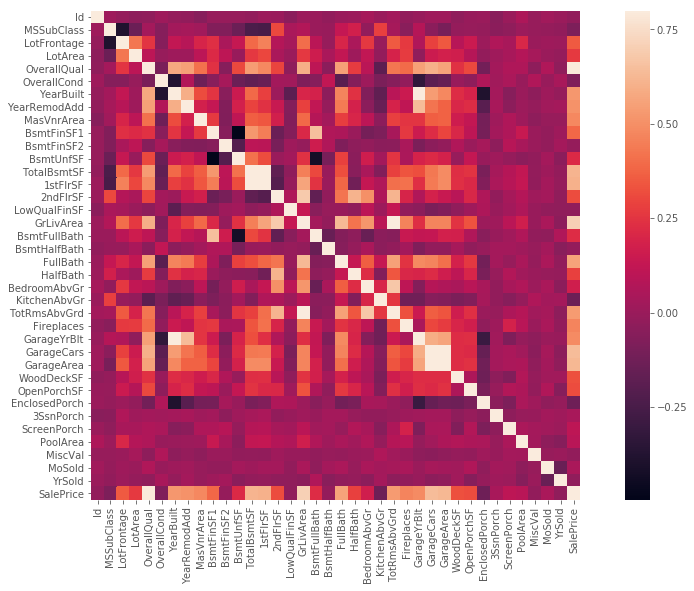

In [8]:
corr_mat = train_data.corr()
f, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);

可以看出 OverallQual, YearBuilt, GrLivArea 等变量更SalePrice有关。

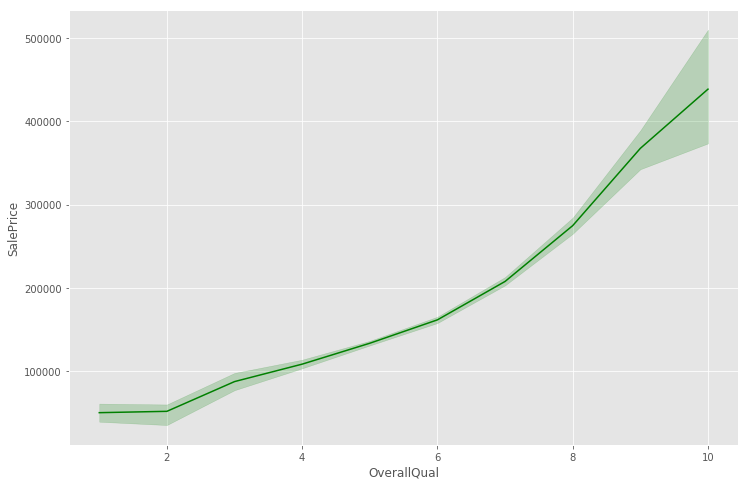

In [9]:
f, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x='OverallQual', y='SalePrice', color='green',data=train_data)

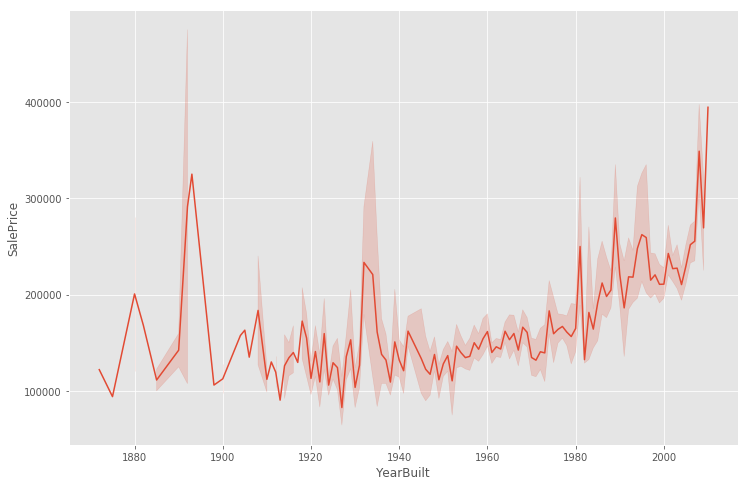

In [10]:
f, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x='YearBuilt', y='SalePrice', data=train_data)

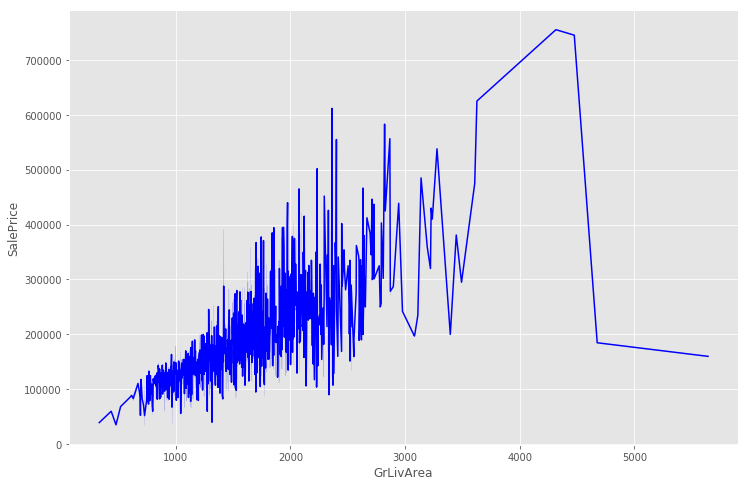

In [11]:
f, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x='GrLivArea', y='SalePrice', color='blue', data=train_data)

我们画图分析，可以认为他们和SalePrice有线性相关性。

### 处理数据

#### 处理missing values

先画出各个变量的missign values，有个直观感受。

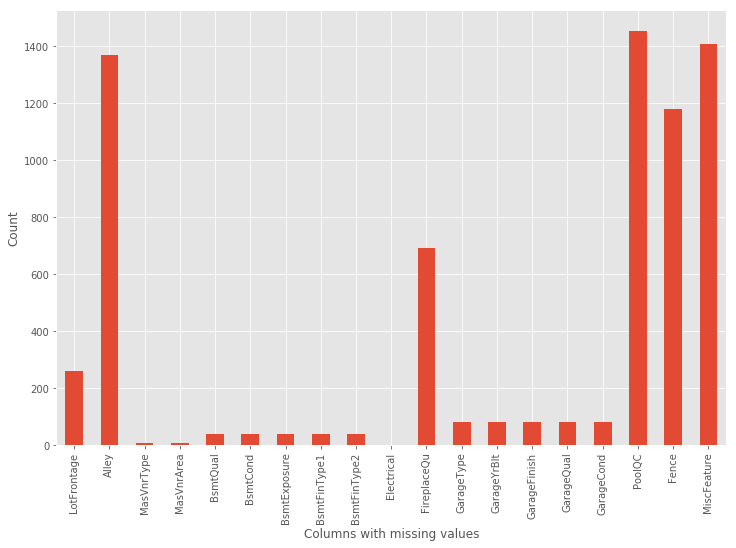

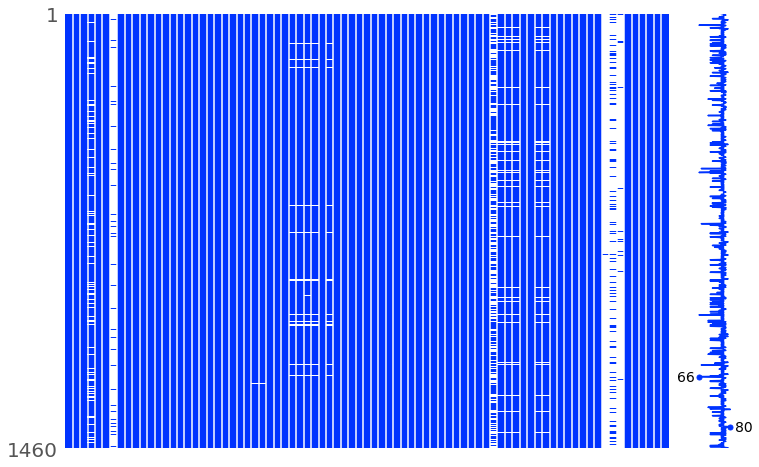

In [12]:
def plot_missing(df):
    nan_sum = df.isnull().sum()
    nan_sum = nan_sum[nan_sum > 0]
    nan_sum.plot.bar(figsize=(12,8))
    plt.xlabel('Columns with missing values')
    plt.ylabel('Count')
    missingno.matrix(df=df, figsize=(12,8), color=(0,0.2,1))
    
plot_missing(train_data)

In [13]:
train = train_data.iloc[:, 1:-1]

missing values 占比太多就drop这个column，剩余的进行填充。

In [14]:
def massive_missing(df, threshod=0.6):
    nan_sum = df.isnull().sum()
    return nan_sum[nan_sum > df.shape[0] * threshod]

missing_series = massive_missing(train, 0.7)
print(missing_series.index)
train = train.drop(missing_series.index, axis=1)

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


给变量做Normalization

In [15]:
numeric_feature = train.dtypes[train.dtypes != 'object'].index
train[numeric_feature] = train[numeric_feature].apply(lambda x: (x - x.mean()) / (x.std()))

对分类型变量插入频率最大的值，对数值型变量插入中数。

In [16]:
def fill_missing_values(df):
    nan_sum = df.isnull().sum()
    nan_sum = nan_sum[nan_sum > 0]
    for column in list(nan_sum.index):
        if df[column].dtype == 'object':
            df[column].fillna(df[column].value_counts().index[0], inplace=True)
        elif df[column].dtype == 'int64' or 'float64':
            df[column].fillna(df[column].median(), inplace=True)
            
fill_missing_values(train)
train.isnull().sum().max()

0

#### one hot representation

In [17]:
train = pd.get_dummies(train)
pd.get_dummies(pd.DataFrame({'a': ['4', '2', '3'], 'b': [1, np.nan, 2]}))

,b,a_2,a_3,a_4
0,1.0,0,0,1
1,NaN,1,0,0
2,2.0,0,1,0


## 3. 构建网络，开始训练

利用gluon可以很方便构建网络，进行训练

In [18]:
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(10, activation='relu'),
            nn.Dense(1))
    net.initialize()
    return net

def training(net, train_features, train_labels, num_epochs, learning_rate, batch_size):
    train_ls = []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        # print('loss: {}, train rmse: {}'.format(l.mean().asscalar(), train_ls[-1]))
    return train_ls

In [19]:
train_features = nd.array(train.values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

num_epochs, learning_rate, batch_size = 300, 0.1, 32
net = get_net()

train_l = training(net, train_features, train_labels, num_epochs, learning_rate, batch_size)
print(train_l)
print('avg train rmse %f' % (train_l[-1], ))

[2.6501935, 1.1841649, 0.49543464, 0.19008583, 0.13642542, 0.1254201, 0.11909374, 0.117759325, 0.118647195, 0.1184914, 0.11652501, 0.11688448, 0.11352708, 0.11160606, 0.11053042, 0.1092266, 0.10570451, 0.10582992, 0.1037772, 0.102216184, 0.10259007, 0.09930266, 0.099895716, 0.09731388, 0.09720213, 0.09671824, 0.09669376, 0.09510688, 0.09511436, 0.09427571, 0.093735866, 0.09317931, 0.0930723, 0.0921398, 0.0925647, 0.09229545, 0.09159845, 0.091816776, 0.090640955, 0.09107688, 0.09020114, 0.09101653, 0.09023459, 0.09008764, 0.08939706, 0.090517774, 0.08979748, 0.089541726, 0.089703426, 0.08877243, 0.089137495, 0.088959865, 0.08940404, 0.08896023, 0.08902202, 0.08936037, 0.08913922, 0.08940124, 0.08862493, 0.08961664, 0.088502385, 0.08900733, 0.08846489, 0.08893931, 0.089770176, 0.088388674, 0.08947082, 0.08853594, 0.08902131, 0.08787544, 0.08868242, 0.08853919, 0.0884819, 0.08827445, 0.088011496, 0.08812093, 0.08876125, 0.088431455, 0.08817731, 0.08803876, 0.08826047, 0.087961495, 0.08826

## 4. 预测

预测时，测试数据要做和训练数据一样的预处理。因为预处理需要drop一些变量，而训练数据和测试数据每个变量的missing value 占比可能不同，就会出现训练和测试数据包含的变量不同，导致训练模型不能用于预测，所以需要把训练数据和测试数据放在一起做预处理。包括归一化等操作也需要大家用相同的期望和方差做归一化。

In [27]:
def preprocess(df):
    missing_series = massive_missing(df, 0.7)
    df = df.drop(missing_series.index, axis=1)
    numeric_feature = df.dtypes[df.dtypes != 'object'].index
    df[numeric_feature] = df[numeric_feature].apply(lambda x: (x - x.mean()) / (x.std()))
    fill_missing_values(df)
    df = pd.get_dummies(df)
    return df

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features = preprocess(all_features)

n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))
test_features = nd.array(all_features[n_train:].values)

In [29]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, batch_size):
    net = get_net()
    train_ls = training(net, train_features, train_labels, num_epochs, learning_rate, batch_size)
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, learning_rate, batch_size)

train rmse 0.085622


## 5.数学原理

#### 定义模型假设

为了容易理解，可以把输入数据x 看成m行n列的矩阵（m个样本，n个自变量），y 看成 m维向量，对应x 中m个样本的因变量，组成有m个方程的方程组。下面公式中x的下标表示n个自变量的序号，上标表示m个样本的序号。

假设(Hypothesis)模型是线性模型：
$$ h_{\theta}(x) = \theta_{1}x_{1} + \theta_{2}x_{2} + ... + \theta_{n}x_{n} = \sum_{i=1}^n \theta_{i}x_{i} $$

因为输入的数据x 是已知的，

模型的损失函数(loss)是：
$$ \ell(\theta) = \frac{1}{2m}\sum_{j=1}^m(h_{\theta}^{(j)}(x) - y^{(j)})^2 = \frac{1}{2m}\sum_{j=1}^m(\theta_{1}x_{1}^{(j)} + \theta_{2}x_{2}^{(j)} + ... + \theta_{n}x_{n}^{(j)} - y^{(j)})^2$$

目标是使损失函数最小化  $ \operatorname*{argmin}_{\theta} \ell(\theta) $

#### 最小化损失函数

我们想用一个多项式函数$f(x) = a_0 + a_1 x + a_2 x^2 + ... + a_n x^n$ 拟合任一曲线函数$g(x)$，则需要满足$f$在某点$a$的各阶导数与$g$在某点$a$的各阶导数相等，可以推导出泰勒展开式

$$f(x) = f(a) + \frac{f^{(1)}(a)}{1!}(x-a)^1 + \frac{f^{(2)}(a)}{2!}(x-a)^2 + \ldots + \frac{f^{(n)}(a)}{n!} (x-a)^n + \ldots,$$

将上式中 $x$ 和 $a$ 分别替换成$x+\epsilon$和$x$ ，可以得到
$$f(x + \epsilon) \approx f(x) + f'(x) \epsilon + \mathcal{O}(\epsilon^2).$$

如果$\epsilon$足够小，上式也可以简化成
$$f(x + \epsilon) \approx f(x) + f'(x) \epsilon.$$

找到一个常数$\eta > 0$，使得$\left|\eta f'(x)\right|$足够小，那么可以将$\epsilon$替换为$-\eta f'(x)$并得到
$$f(x - \eta f'(x)) \approx f(x) -  \eta f'(x)^2.$$

如果导数$f'(x) \neq 0$，那么$\eta f'(x)^2>0$，所以
$$f(x - \eta f'(x)) \lesssim f(x).$$

这意味着，如果通过
$$x \leftarrow x - \eta f'(x)$$
来迭代$x$，函数$f(x)$的值可能会降低。因此在梯度下降中，我们先选取一个初始值$x$和常数$\eta > 0$，然后不断通过上式来迭代$x$，直到达到停止条件，例如$f'(x)^2$的值已足够小或迭代次数已达到某个值。

这里要求$\eta$足够小，并且$f'(x)$ 足够小，不然假设不成立。也就是说在最好对数据做归一化，不然输入值太大，导数的值也会很大。

#### 什么是梯度

偏导数是函数沿坐标轴方向的变化率，方向导数是函数沿着某个方向的变化率，例如函数 $f(x,y)$ 在点 $P_0(x_0,y_0)$ 可微分，那么函数在该点沿任一方向d 的方向导数存在，$e_d = (a,b)$是方向为d 的单位向量。
$$ \frac{\partial f}{\partial d}|(x_0,y_0) = f_x(x_0,y_0)a + f_y(x_0,y_0)b $$

梯度是一个矢量，有大小和方向，可以理解成空间中的射线。梯度表示某函数，在一点处，方向导数沿着这个方向取得了最大值，方向是梯度方向，变化率最大，也是梯度大小（模）。函数 $f(x,y)$ 在点 $P_0(x_0,y_0)$ 的梯度，一般写成 $grad f(x_0,y_0)$或 $\nabla f(x_0,y_0) $。一般梯度写为 $\nabla f = (f_x,f_y)$。 那么方向导数和梯度是什么关系？

$$ \frac{\partial f}{\partial d}|(x_0,y_0) = f_x(x_0,y_0)a + f_y(x_0,y_0)b $$
$$ = \nabla f(x_0,y_0) \cdot e_d $$
$$ = |\nabla f(x_0,y_0)| \cdot cos\beta $$
其中 $\beta  $ 是梯度与方向d 单位向量的夹角，当夹角为0 时，方向导数与梯度同方向，并取得最大值。

#### 多维梯度下降

目标函数的输入为向量，输出为标量。在多维空间中，比如这里n维向量 $ x^{(j)} = [x_{1}^{(j)}, x_{2}^{(j)}, ..., x_{n}^{(j)}], 1 \leq j \leq m $, 函数在这一点的变化最快的方向，就是梯度方向，方向导数沿着这个方向取得了最大值。目标函数$f(\boldsymbol{x})$有关$\boldsymbol{x}$的梯度是一个由$n$个偏导数组成的向量：

$$\nabla f(\boldsymbol{x}) = \bigg[\frac{\partial f(\boldsymbol{x})}{\partial x_1^{(j)}}, \frac{\partial f(\boldsymbol{x})}{\partial x_2^{(j)}}, \ldots, \frac{\partial f(\boldsymbol{x})}{\partial x_n^{(j)}}\bigg]$$

$f$ 沿着单位向量 $\boldsymbol{u}$（$\|\boldsymbol{u}\|=1$）方向上的变化率，即定义 $f$ 在 $\boldsymbol{x}$ 上沿着$\boldsymbol{u}$方向的方向导数为

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \lim_{h \rightarrow 0}  \frac{f(\boldsymbol{x} + h \boldsymbol{u}) - f(\boldsymbol{x})}{h} = \nabla f(\boldsymbol{x}) \cdot \boldsymbol{u}$$
$$= |\nabla f(\boldsymbol{x})| \cdot |u| \cdot cos(\beta) = |\nabla f(\boldsymbol{x})| \cdot cos(\beta) $$

$\beta$ 为梯度 $\nabla f(\boldsymbol{x})$ 和单位向量$\boldsymbol{u}$之间的夹角，为了找到 $f$ 降低最快的方向，令$\beta = 0$时，$cos(\beta)$ 取得最大值 1 。